In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model


# Exchange Rate GARCH: Baseline Model

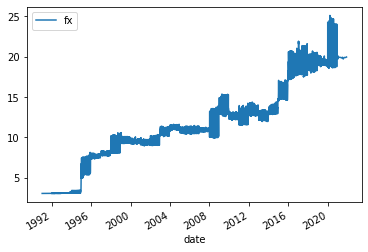

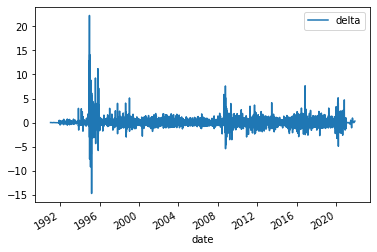

In [3]:
bmx_df = pd.read_csv('csv_files/bmx.csv')

bmx = (bmx_df
       .assign(
           delta = 100 * bmx_df.fx.pct_change().dropna(),
           date = pd.to_datetime(bmx_df.date)
              )
      )

bmx.plot(x='date', y='fx')
bmx.plot(x='date', y='delta')

bmx_clean = bmx[bmx.date >= dt.datetime(1996,1,1)]

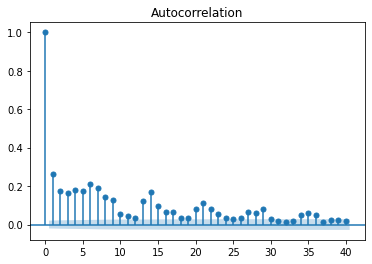

In [4]:
squared_data = bmx_clean.delta.values**2

plot_acf(squared_data)
plt.show()

In [5]:
data = bmx_clean.delta
data.index = bmx_clean.date
split_date = dt.datetime(2016,1,1)

am = arch_model(data, vol='Garch', p=1, o=0, q=1, dist='skewt')

res = am.fit(last_obs=split_date)

ValueError: date_index is not monotonic and unique

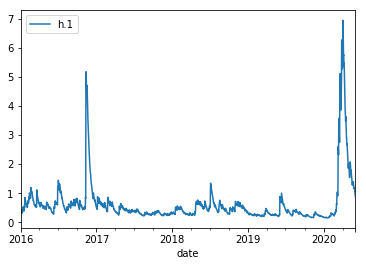

In [5]:
forecasts = res.forecast(horizon = 1, start=split_date)
forecasts.variance[split_date:].plot()

(13879, 14244)

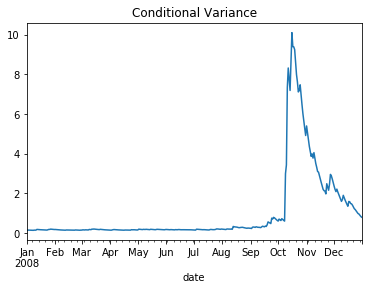

In [7]:
fig, ax = plt.subplots(1, 1)
var = res.conditional_volatility['2008']**2.0
subplot = var.plot(ax=ax, title='Conditional Variance')
subplot.set_xlim(var.index[0], var.index[-1])

# Bootstrap

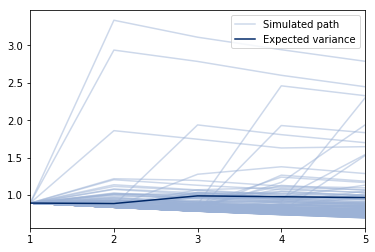

In [8]:
forecasts = res.forecast(horizon=5, method='simulation')
sims = forecasts.simulations

x = np.arange(1, 6)
lines = plt.plot(x, sims.residual_variances[-1, ::5].T, color='#9cb2d6', alpha=0.5)
lines[0].set_label('Simulated path')
line = plt.plot(x, forecasts.variance.iloc[-1].values, color='#002868')
line[0].set_label('Expected variance')
plt.gca().set_xticks(x)
plt.gca().set_xlim(1,5)
legend = plt.legend()

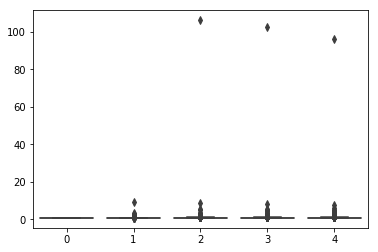

In [9]:
sns.boxplot(data=sims.variances[-1])

# GARCH

In [11]:
am = arch_model(data, vol='Garch', p=1, o=0, q=1, dist='skewt')
res = am.fit(disp='off', last_obs='2017-12-31')

/opt/anaconda3/envs/main/lib/python3.5/site-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2837. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


In [31]:
forecasts = res.forecast(start='2019-1-1')
cond_mean = forecasts.mean['2019':]
cond_var = forecasts.variance['2019':]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.3280759  -1.11250184]


<Figure size 2880x1440 with 0 Axes>

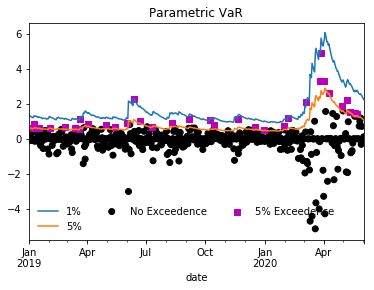

In [32]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)

plt.figure(figsize=(40,20)) 
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = data['2019':].copy()
rets_2018.name = 'USD/MXN Depreciation'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
ax.set_title('Parametric VaR')

leg = ax.legend(frameon=False, ncol=3)

plt.show()

In [33]:
res

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                             delta   R-squared:                      -0.001
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                                 GARCH   Log-Likelihood:               -4045.41
Distribution:      Standardized Skew Student's t   AIC:                           8102.82
Method:                       Maximum Likelihood   BIC:                           8144.77
                                                   No. Observations:                 8035
Date:                           Sat, May 30 2020   Df Residuals:                     8029
Time:                                   22:46:56   Df Model:                            6
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------